In [1]:
#   ======================   #
#%% CALCULATION PARAMETERS %%#
#   ======================   #   

orbital = "SimpleButterfly"
norbitals = 3

# construction and diagonalization in a single step
onestep = true
# use precomputed spin-CG coefficients
spinarray = true
# parallel computation
distributed = parallel = false
# parallel method: distfor or async
method = "distfor"
# discretization ("standard" or "co2005")
discretization = "co2005"

# clean system or with impurity added
calculation = "IMP"

# twisting parameter
z = 0.0

# numerical parameters
L = 10.0
betabar = 1.0

# cutoff
cutoff_type = "multiplet" 
cutoff_magnitude = 200
minmult = 0

# hamiltonian parameters
E0 = -0.1
E1 =  0.1
gam = 0.07

# command-line input
if length(ARGS)>0
    # clean/imp
    calculation = "IMP"
    if ARGS[1]=="CLEAN" 
        calculation = "CLEAN"
    end
    # twisting parameter
    if length(ARGS)>1
        z = parse(Float64,ARGS[2])
    end
    # relative parameters
    if length(ARGS)>2
        u_11_r = parse(Float64,ARGS[3])
        u_h_r  = parse(Float64,ARGS[4]) 
        gam_r  = parse(Float64,ARGS[5])
    end
end

iterations = 40

max_spin2 = 8

distworkers = 6

println( "====================" )
println( "SETUP AND PARAMETERS" )
println( "====================" )
@show calculation
@show distributed 
distributed && @show distworkers
@show method
@show discretization
@show z
@show cutoff_type
@show cutoff_magnitude
@show iterations
@show max_spin2
@show betabar
@show L
@show E0
@show E1 
@show gam  
println()

SETUP AND PARAMETERS
calculation = "IMP"
distributed = false
method = "distfor"
discretization = "co2005"
z = 0.0
cutoff_type = "multiplet"
cutoff_magnitude = 200
iterations = 40
max_spin2 = 8
betabar = 1.0
L = 10.0
E0 = -0.1
E1 = 0.1
gam = 0.07



In [2]:
#   =======================   #
#%% MODULES AND DISTRIBUTED %%#
#   =======================   #

using DelimitedFiles
using ProfileVega
using Profile

include( "modules/symbols.jl" )
include( "modules/numericals.jl" )
include( "modules/compoundoperators.jl" )
include( "modules/shell.jl" )
include( "modules/thermo.jl" )
include( "modules/discretization.jl" )

if parallel 

    using Distributed 

    # kill current processes
    for i in workers()
        t = rmprocs(i, waitfor=0)
        wait(t)
    end

    # add requested workers
    if distworkers ≥ nprocs()
        addprocs(distworkers)
    else 
        println( "more workers than processors!" )
    end

    println( "DISTRIBUTED CALCULATION WITH $(nworkers()) WORKERS" )

    @everywhere begin 
        using ProgressMeter
        using PartialWaveFunctions
        using StaticArrays
        include( "modules/symmetry.jl" )
        include( "modules/diagonalization.jl" )
    end

else 

    println( "SERIAL CALCULATION" )

    using ProgressMeter
    using PartialWaveFunctions
    using StaticArrays

    include( "modules/symmetry.jl" )
    include( "modules/diagonalization.jl" )

end

SERIAL CALCULATION


get_pseudoCG_up_vp (generic function with 3 methods)

In [3]:
#   ======================   #
#%% ORBITAL CLEBSCH-GORDAN %%#
#   ======================   #

CG_PATH = "/home/aitor/Bulegoa/ClebschGordan/Oh/cg_symbolic/"
ASYM_PATH = "/home/aitor/Bulegoa/AntiSymmetricPart/Oh/";

ORBITAL_IRREPS = ( "A1g" , )
oirreps = cg_shortcircuit( CG_PATH , ORBITAL_IRREPS... )
oirreps2indices = Dict( o=>i for (i,o) in enumerate(oirreps) )
oirreps2dimensions = Dict( "A1g"=> 1 )
oindex2dimensions = collect( oirreps2dimensions[I] for I in oirreps )
println( "ORBITAL IRREPS FOR THE PROBLEM" )
println( oirreps )
println()

cg_o_full = get_cg_o_fulldict( oirreps , CG_PATH )
cg_o_fullmatint = get_cg_o_fullmatint( cg_o_full , oirreps )
println( "ORBITAL CLEBSCH-GORDAN" )
print_dict( cg_o_fullmatint )
println()


#   ===================   #
#%% SPIN CLEBSCH-GORDAN %%#
#   ===================   #
cg_s_fullmatint = get_cg_s_fullmatint( max_spin2 );
println( "SPIN CLEBSCH-GORDAN" )


ORBITAL IRREPS FOR THE PROBLEM
["A1g"]

ORBITAL CLEBSCH-GORDAN
(1, 1, 1)
ComplexF64[1.0 + 0.0im]


SPIN CLEBSCH-GORDAN


In [4]:
#   ==================================   #
#&& ONE-SHELL SYMSTATES AND MULTIPLETS &&#
#   ==================================   #

#   --------------------- #
#%% atomic symstate basis #
#   --------------------- #
identityrep = "A1g"
hiztegia = Dict( 
    "o1" => "A1g",
    "o2" => "A1g",
    "o3" => "A1g",
    "u" =>  0.5 ,
    "d" => -0.5
)

# orbital 1
o1 = (0,"o1")                                                                       
o1_up = ( o1... , 1 , "u" )                                                             
o1_do = ( o1... , 1 , "d" )                                                             
hilbert_o1 = HilbertSpace([ o1_up , o1_do ])
symstates_o1_nor = oneirrep_symstates( 
                    hilbert_o1 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o1 = Dict( (q[1:5]...,1)=>s 
                    for (q,s) in symstates_o1_nor )
# orbital 2 (b)
o2 = (0,"o2")                                                                        
o2_up = ( o2... , 1 , "u" )                                                             
o2_do = ( o2... , 1 , "d" )                                                             
hilbert_o2 = HilbertSpace([ o2_up , o2_do ])
symstates_o2_nor = oneirrep_symstates( 
                    hilbert_o2 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o2 = Dict( (q[1:5]...,2)=>s 
                    for (q,s) in symstates_o2_nor )
# orbital 3 (c)
o3 = (0,"o3")                                                                       
o3_up = ( o3... , 1 , "u" )                                                             
o3_do = ( o3... , 1 , "d" )                                                             
hilbert_o3 = HilbertSpace([ o3_up , o3_do ])
symstates_o3_nor = oneirrep_symstates( 
                    hilbert_o3 , 
                    hiztegia ,
                    identityrep ,
                    "$(ASYM_PATH)$(identityrep)_julia/" ) 
symstates_o3 = Dict( (q[1:5]...,3)=>s 
                    for (q,s) in symstates_o3_nor )

# mix 
symstates_12 = cg_reduce_product_states( symstates_o1 ,
                                         symstates_o2 ,
                                         CG_PATH )
symstates_0  = cg_reduce_product_states( symstates_12 ,
                                         symstates_o3  ,
                                         CG_PATH )

# basis 
basis_0 = collect(values(symstates_0))[1].basis 

# multiplets 
multiplets_0 = get_multiplets( symstates_0 )

# printing
println( "BASIS FOR ATOMIC SHELL" )                                               
println( basis_0 )
println()
#println( "SYMSTATES" )
#print_symstates_Nordered( symstates_0 )
#println( "ATOMIC MULTIPLETS" )
#print_multiplets_Nordered( multiplets_0 )
#println()
##   ------------------ #
##%% selected symstates #
##   ------------------ #

# creation operators 
cre_1u = Operator( SymbolCreationOperator(o1_up) , basis_0 )
cre_1d = Operator( SymbolCreationOperator(o1_do) , basis_0 )
cre_2u = Operator( SymbolCreationOperator(o2_up) , basis_0 )
cre_2d = Operator( SymbolCreationOperator(o2_do) , basis_0 )
cre_3u = Operator( SymbolCreationOperator(o3_up) , basis_0 )
cre_3d = Operator( SymbolCreationOperator(o3_do) , basis_0 )

# vacuum (seed) states
vac = State( basis_0.states[1] , basis_0 )

# 0 multiplet: spin-1/2 doublet
i0 = (3,"A1g",0.5)::Tuple{Int64,String,Float64}
m0 = (3,"A1g",0.5,1)::Tuple{Int64,String,Float64,Int64}
slat_2u0 = cre_1u*cre_1d*cre_2u*vac
slat_0u2 = cre_2u*cre_3u*cre_3d*vac 
slat_udu = cre_1u*cre_2d*cre_3u*vac
slat_uud = cre_1u*cre_1u*cre_1d*vac
s_0_p05 =  0.70*slat_2u0 + 
           0.47*slat_0u2 + 
           0.38*slat_udu + 
           0.21*slat_uud
normalize!( s_0_p05 )
slat_2d0 = cre_1u*cre_1d*cre_2d*vac
slat_0d2 = cre_2d*cre_3u*cre_3d*vac
slat_dud = cre_1d*cre_2u*cre_3d*vac
slat_ddu = cre_1d*cre_2d*cre_3u*vac
s_0_m05 =  0.70*slat_2d0 + 
           0.47*slat_0d2 + 
           0.38*slat_dud + 
           0.21*slat_ddu
normalize!( s_0_m05 )

# 1 multiplet: spin-0 singlet 
i1 = (2,"A1g",0.0)::Tuple{Int64,String,Float64}
m1 = (2,"A1g",0.0,1)::Tuple{Int64,String,Float64,Int64}
slat_200 = cre_1u*cre_1d*vac
s_1_0 = slat_200
normalize!( s_1_0 )

# selected symstates and multiplets
multiplets_atom = Set([ m0 , m1 ])
println( "***********************************************************************")
println( "ATOMIC SELECTED MULTIPLETS" )
print_multiplets_Nordered( multiplets_atom )
symstates_atom  = Dict{ Tuple{Int64,String,Float64,Int64,Float64,Int64} , State }( 
                 (i0...,1, 0.5,1)=>s_0_p05 ,
                 (i0...,1,-0.5,1)=>s_0_m05 ,
                 (i1...,1, 0.0,1)=>s_1_0   
                )
println( "ATOMIC SELECTED SYMSTATES" )
print_symstates_Nordered( symstates_atom )
println( "***********************************************************************")
println()


##   =================== #
##&& INITIAL HAMILTONIAN #
##   =================== #

# parameter renormalization
if discretization=="standard"
    global α = 0.5 * L^z * (1+L^-1)
elseif discretization=="co2005"
    global α = compute_ebar0_z(z,L;discretization=discretization)
end
E0  /= α
E1  /= α
gam /= α


#   ----- #
#%% irreu #
#   ----- #
irrEU_clean = get_irrEU_clean( "A1g" )
irrEU_imp   = Dict{Tuple{Int64, String, Float64}, Tuple{Vector{Float64}, Matrix{ComplexF64}}}( 
                   i0 => ([E0],[ComplexF64(1.0)][:,:]) ,
                   i1 => ([E1],[ComplexF64(1.0)][:,:]) )
if calculation=="IMP" 
    multiplets_block = multiplets_atom 
    global irrEU = irrEU_imp
elseif calculation=="CLEAN" 
    multiplets_block = Set([ (0,"A1g",0.0,1) ])
    global irrEU = irrEU_clean
end



BASIS FOR ATOMIC SHELL
1: |)
2: | 0 o3 1 u )
3: | 0 o3 1 d )
4: | 0 o3 1 u , 0 o3 1 d )
5: | 0 o2 1 u )
6: | 0 o2 1 u , 0 o3 1 u )
7: | 0 o2 1 u , 0 o3 1 d )
8: | 0 o2 1 u , 0 o3 1 u , 0 o3 1 d )
9: | 0 o2 1 d )
10: | 0 o2 1 d , 0 o3 1 u )
11: | 0 o2 1 d , 0 o3 1 d )
12: | 0 o2 1 d , 0 o3 1 u , 0 o3 1 d )
13: | 0 o2 1 u , 0 o2 1 d )
14: | 0 o2 1 u , 0 o2 1 d , 0 o3 1 u )
15: | 0 o2 1 u , 0 o2 1 d , 0 o3 1 d )
16: | 0 o2 1 u , 0 o2 1 d , 0 o3 1 u , 0 o3 1 d )
17: | 0 o1 1 u )
18: | 0 o1 1 u , 0 o3 1 u )
19: | 0 o1 1 u , 0 o3 1 d )
20: | 0 o1 1 u , 0 o3 1 u , 0 o3 1 d )
21: | 0 o1 1 u , 0 o2 1 u )
22: | 0 o1 1 u , 0 o2 1 u , 0 o3 1 u )
23: | 0 o1 1 u , 0 o2 1 u , 0 o3 1 d )
24: | 0 o1 1 u , 0 o2 1 u , 0 o3 1 u , 0 o3 1 d )
25: | 0 o1 1 u , 0 o2 1 d )
26: | 0 o1 1 u , 0 o2 1 d , 0 o3 1 u )
27: | 0 o1 1 u , 0 o2 1 d , 0 o3 1 d )
28: | 0 o1 1 u , 0 o2 1 d , 0 o3 1 u , 0 o3 1 d )
29: | 0 o1 1 u , 0 o2 1 u , 0 o2 1 d )
30: | 0 o1 1 u , 0 o2 1 u , 0 o2 1 d , 0 o3 1 u )
31: | 0 o1 1 u , 0 o2 1 

Dict{Tuple{Int64, String, Float64}, Tuple{Vector{Float64}, Matrix{ComplexF64}}} with 2 entries:
  (3, "A1g", 0.5) => ([-0.255843], [1.0+0.0im])
  (2, "A1g", 0.0) => ([0.255843], [1.0+0.0im])

In [5]:
##   ================================================   #
##&& NUMERICAL ADDITION OF INNERMOST CONDUCTION SHELL &&#
##   ================================================   #

#   ---------------   #
#%% combinations u' %%#
#   ---------------   #
combinations_uprima = 
    Dict{ Tuple{Int64,Int64,Int64,Int64} , NTuple{2,Tuple{Int64,Int64,Int64,Int64}} }()
m_vac = (0,oirreps2indices["A1g"],0,1)
if calculation=="IMP"
    for m_mu in multiplets_atom
        mint_mu = convert_to_int( m_mu , oirreps2indices )
        push!( combinations_uprima , mint_mu=>(mint_mu,m_vac) )
    end 
elseif calculation=="CLEAN" 
    push!( combinations_uprima , m_vac=>(m_vac,m_vac) )
end

irreps_uprima = Set( k[1:3] for k in keys(combinations_uprima) )
combinations_uprima = 
        Dict{ NTuple{3,Int64} , Vector{NTuple{3,NTuple{4,Int64}}} }(
            G => NTuple{3,NTuple{4,Int64}}[
                (m_u,m_mu,m_i)
                for (m_u,(m_mu,m_i)) in combinations_uprima 
                if m_u[1:3]==G
                ]
            for G in irreps_uprima
        ) 
println( "COMBINATIONS U' FOR N=0" )
for (G,combs) in combinations_uprima
    println( "$G => $combs" )
end
println()

#   ---------------------------   #
#%% atom pseudo-CG coefficients %%#
#   ---------------------------   #

# hoppers
pcg_atom = Dict{NTuple{3,Tuple{Int64,String,Float64,Int64,Float64,Int64}},ComplexF64}()
q_2up = (1,"A1g",0.5,1, 0.5,2)
q_2do = (1,"A1g",0.5,1,-0.5,2)
qq_a  = [q_2up,q_2do] 
println( "ONE-PARTICLE HOPPERS" )
@show qq_a
println()

# pcg
for (q1,s1) in symstates_atom,
    (q2,s2) in symstates_atom

    cup = s1 * cre_2u * s2 
    cdo = s1 * cre_2d * s2

    isapprox(cup,0.0) || (pcg_atom[(q1,q_2up,q2)]=cup)
    isapprox(cdo,0.0) || (pcg_atom[(q1,q_2do,q2)]=cdo)

end
println( "======================" )
println( "PSEUDO-CG COEFFICIENTS" )
println( "======================" )
println( "ATOMIC PCG" )
print_dict( pcg_atom )
println()

#   ----------------------------------- #
#%% shell symstates, multiplets and pcg #
#   ----------------------------------- #

# symstates
s_shell_0_0 = vac
s_shell_1_u = cre_2u*vac
s_shell_1_d = cre_2d*vac
s_shell_2_0 = cre_2u*cre_2d*vac
symstates_shell = Dict{Tuple{Int64,String,Float64,Int64,Float64,Int64},State}(
                    (0,"A1g",0.0,1, 0.0,1)=>s_shell_0_0 ,
                    (1,"A1g",0.5,1, 0.5,1)=>s_shell_1_u ,
                    (1,"A1g",0.5,1,-0.5,1)=>s_shell_1_d ,
                    (2,"A1g",0.0,1, 0.0,1)=>s_shell_2_0 
                   )
println( "***********************************************************************")
println( "SHELL SELECTED SYMSTATES" )
print_dict( symstates_shell )

# multiplets
multiplets_shell = Set( (q[1:3]...,q[end]) for q in keys(symstates_shell) )
irrmult_shell = get_irreps( multiplets_shell ; multiplicity=true )
println( "SHELL SELECTED MULTIPLETS" )
for m in multiplets_shell
    println( m )
end
println( "***********************************************************************")
println()

# pcg
pcg_shell = Dict{NTuple{3,Tuple{Int64,String,Float64,Int64,Float64,Int64}},ComplexF64}()
for (q1,s1) in symstates_shell,
    (q2,s2) in symstates_shell

    cup = s1 * cre_2u * s2 
    cdo = s1 * cre_2d * s2

    isapprox(cup,0.0) || (pcg_shell[(q1,q_2up,q2)]=cup)
    isapprox(cdo,0.0) || (pcg_shell[(q1,q_2do,q2)]=cdo)
end
println( "SHELL PCG" )
print_dict( pcg_shell )
println()

#   -----------------   #
#%% hopping parameter %%#
#   -----------------   #
hop = Dict( 
    (oirreps2indices["A1g"],2) => ComplexF64(gam) 
)
println( "ATOM-SHELL HOPPING PARAMETER" )
@show hop
println()


#   ------------------------ #
##% conversion to int format #
#   ------------------------ #
multiplets_block = Set([ convert_to_int(m,oirreps2indices) for m in multiplets_block ])
multiplets_shell = Set([ convert_to_int(m,oirreps2indices) for m in multiplets_shell ])
irrEU = Dict( convert_to_int(G,oirreps2indices)=>x for (G,x) in irrEU )
qq_a = [ convert_to_int(q,oirreps2indices) for q in qq_a ]
pcg_atom  = Dict( (convert_to_int(k[1],oirreps2indices),
                   convert_to_int(k[2],oirreps2indices),
                   convert_to_int(k[3],oirreps2indices))=>v for (k,v) in pcg_atom )
pcg_shell = Dict( (convert_to_int(k[1],oirreps2indices),
                   convert_to_int(k[2],oirreps2indices),
                   convert_to_int(k[3],oirreps2indices))=>v for (k,v) in pcg_shell )


#   ------------------- #
#%% impurity multiplets #
#   ------------------- #
function ordered_multiplets( mults ) 
    max_N = maximum(k[1] for k in mults) 
    omults = []
    for N in 0:max_N 
        for mult in mults
            mult[1]==N || continue
            push!(omults,mult)
        end
    end
    return omults
end

println("IMPURITY MULTIPLET SPACE")
omults = ordered_multiplets(multiplets_block)
mult2index = Dict( m=>i for (i,m) in 
                   enumerate(omults))
mm_i = Dict( 
            m=>[(i==mult2index[m] ? 1.0 : 0.0)
                for i in 1:length(multiplets_block)] 
                for m in omults
           )
@show mm_i 
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )

#   --------------------------------------- #
#%% diagonalization: atom + innermost shell #
#   --------------------------------------- #
println( "irrEU before adding the innermost shell" )
print_dict( irrEU )
println()
if distributed
    @time begin 
    global (irrEU,combinations_uprima) = matdiag_distributed(
                            multiplets_block ,
                            multiplets_shell ,
                            irrEU ,
                            hop ,
                            cg_o_fullmatint ,
                            cg_s_fullmatint ,
                            pcg_atom ,
                            pcg_shell ,
                            qq_a ,
                            combinations_uprima ,
                            oindex2dimensions ;
                            verbose=false )
    end
else
    @time begin 
    global (irrEU,combinations_uprima) = matdiag_serial(
                            multiplets_block ,
                            multiplets_shell ,
                            irrEU ,
                            hop ,
                            cg_o_fullmatint ,
                            cg_s_fullmatint ,
                            pcg_atom ,
                            pcg_shell ,
                            qq_a ,
                            combinations_uprima ,
                            oindex2dimensions ;
                            verbose=false )
    end
end
#minE = minimum([e for (E,U) in values(irrEU) for e in E])
#irrEU = Dict( G=>(E.-minE,U) for (G,(E,U)) in irrEU )
println( "irrEU after adding the innermost shell" )
print_dict( irrEU )
println()

# impurity thermodynamics 
mm_i = imp_mults( irrEU ,
                  oindex2dimensions ,
                  combinations_uprima ,
                  mm_i )
m_imp = mult_thermo( irrEU ,
                     betabar ,
                     oindex2dimensions ,
                     mm_i )
println( "IMPURITY THERMODYNAMICS" )
@show mm_i
@show m_imp
println()


COMBINATIONS U' FOR N=0
(3, 1, 1) => [((3, 1, 1, 1), (3, 1, 1, 1), (0, 1, 0, 1))]
(2, 1, 0) => [((2, 1, 0, 1), (2, 1, 0, 1), (0, 1, 0, 1))]

ONE-PARTICLE HOPPERS
qq_a = [(1, "A1g", 0.5, 1, 0.5, 2), (1, "A1g", 0.5, 1, -0.5, 2)]

PSEUDO-CG COEFFICIENTS
ATOMIC PCG
((3, "A1g", 0.5, 1, 0.5, 1), (1, "A1g", 0.5, 1, 0.5, 2), (2, "A1g", 0.0, 1, 0.0, 1))
0.7569005206913559 + 0.0im

((3, "A1g", 0.5, 1, -0.5, 1), (1, "A1g", 0.5, 1, -0.5, 2), (2, "A1g", 0.0, 1, 0.0, 1))
0.7381108653475712 + 0.0im


***********************************************************************
SHELL SELECTED SYMSTATES
(0, "A1g", 0.0, 1, 0.0, 1)
(1.0 + 0.0im) |)

(1, "A1g", 0.5, 1, 0.5, 1)
(1.0 + 0.0im) | 0 o2 1 u )

(2, "A1g", 0.0, 1, 0.0, 1)
(1.0 + 0.0im) | 0 o2 1 u , 0 o2 1 d )

(1, "A1g", 0.5, 1, -0.5, 1)
(1.0 + 0.0im) | 0 o2 1 d )

SHELL SELECTED MULTIPLETS
(1, "A1g", 0.5, 1)
(0, "A1g", 0.0, 1)
(2, "A1g", 0.0, 1)
***********************************************************************

SHELL PCG
((2, "A1g", 0.0, 1, 0.0,

In [6]:
#   =============== #
#%% NRG CALCULATION #
#   =============== #

# shell pcgmat (before conversion to int)
# get_irreps() seems to need string representation... fail
pcgmat_shell = get_pseudoCG_mat( pcg_shell , irrmult_shell , oindex2dimensions );
println()

# hopchannels 
hopchannels = collect(keys( hop ))

# actual NRG
@profile global nrg = NRG( iterations , 
           cutoff_type , 
           cutoff_magnitude ,
           L ,
           hopchannels ,
           irrEU ,
           multiplets_shell ,
           cg_o_fullmatint ,
           pcg_shell , 
           pcgmat_shell , 
           qq_a , 
           combinations_uprima ,
           betabar ,
           oindex2dimensions ,
           mm_i ;
           spinarray=false ,
           cg_s_fullmatint,
           distributed=distributed ,
           method=method ,
           minmult=minmult , 
           z=z ,
           discretization=discretization );


NRG PROCEDURE

ITERATION n=2
Applying cutoff to obtain block multiplets...   0.000012 seconds (44 allocations: 4.625 KiB)
7 multiplets kept (12 states), 0 multiplets discarded
proportion: 100.0%. max energy: 0.6365478532272717. max spin: 2
Renormalizing eigenvalues...
hop = Dict{Tuple{Int64, Int64}, ComplexF64}((1, 2) => 0.949157996701657 + 0.0im)
shell hopping = 0.9491579967016569872598870061782055794435902459145845959773787545566570511461326
Diagonalizing Hamiltonian...
(ppp.time, ppp.bytes * 10 ^ -6, ppp.gctime) = (0.000335537, 0.2722080000000001, 0.0)
m_imp = [0.10289765118266661, 0.8971023488173333]
THERMODYNAMICS
t = 0.55
ρ = 8.15418600909787
entr = 2.098531416142988
mag = 0.4212868671572179
N = 1.1884044305379715
en = 1.1868464855860426

ITERATION n=3
Applying cutoff to obtain block multiplets...   0.000012 seconds (68 allocations: 12.070 KiB)
25 multiplets kept (48 states), 0 multiplets discarded
proportion: 100.0%. max energy: 5.520899142716813. max spin: 3
Renormalizing eige

In [7]:
#   ===========   #
#%% PERFORMANCE %%#
#   ===========   #

println( "===========" )
println( "PERFORMANCE" )
println( "===========" )
print_performance_onestep(nrg)
println()

PERFORMANCE
TIME (s)
minimum time: 0.000335537
maximum time: 0.586626727
mean time:    0.44985705664102565

minimum gigabytes: 0.000272208
maximum gigabytes: 0.03157141
mean gigabytes:    0.02672898446153846

minimum gc time: 0.0
maximum gc time: 0.101644402
mean gc time:    0.008391410128205129



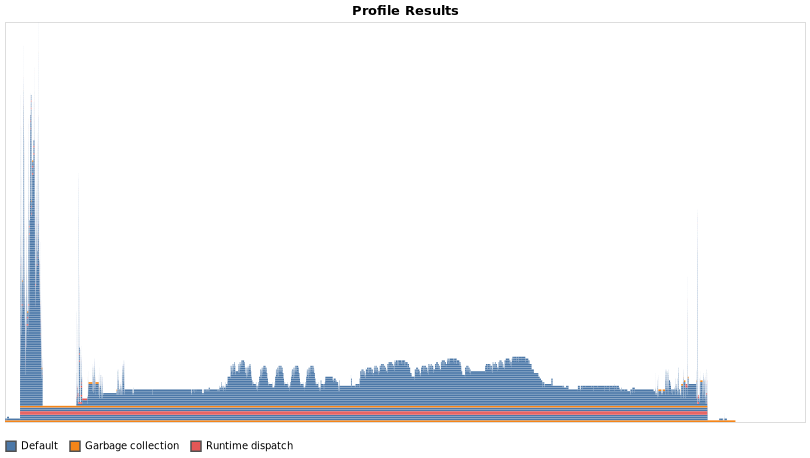

In [8]:
ProfileVega.view()

In [2]:
a = [1,2,3]
function change( x ) 
    x += 2 
end
change(a[2]) 
a

3-element Vector{Int64}:
 1
 2
 3

In [7]:
using Distributed

@sync for i=1:2 
    @async begin 
        x = @sync @fetch begin 
            sleep(3)
            i 
        end 
        @show x 
    end 
end

x = 1
x = 2


In [5]:
@show nprocs()


nprocs() = 9


9

In [1]:
for calc in ["CLEAN","IMP"]
    @show calc 
end

calc = "CLEAN"
calc = "IMP"
